In [1]:
"""
Rooftop Image Classification from Satellite Imagery
Denver,CO

Brittany Bennett
December 2018 
"""

"""
Given an image, perform random transformations to generate new data. 
 
"""

# Import the necessary packages
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2 as cv
import os
import numpy as np



In [2]:
from keras.preprocessing.image import ImageDataGenerator


/home/thebbennett/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
os.chdir("Images/compressed/images/resized/")

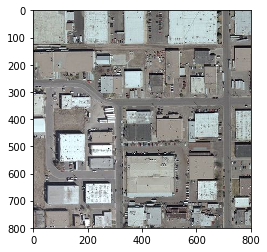

In [4]:
path ="036719ne051sw_compressed_resized.jpg"
img=mpimg.imread(path)
imgplot = plt.imshow(img)

In [15]:
datagen_args = dict(rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
datagen = ImageDataGenerator(**datagen_args)

path ="036719ne051sw_compressed_resized.jpg"
img=mpimg.imread(path)


In [16]:
augmented = datagen.random_transform(img)

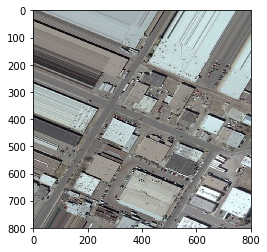

In [17]:
imgplot = plt.imshow(augmented)